TODO: ensure that one creates high resolution path. Then consider $\Delta W^{h}_{n} = \Delta W^{2h}_{n+1} + \Delta W^{2h}_n$ since $\Delta W^{2h}_{n+1} + \Delta W^{2h}_n = W^{2h}(t_{n+2})-W^{2h}(t_{n+1}) + W^{2h}(t_{n+1})-W^{2h}(t_{n})) = W^{h}(t_{n+1})-W^{h}(t_{n}) = \Delta W^{h}_n$

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax.config import config
config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

In [2]:
key1 = jax.random.PRNGKey(0)
i=8
dt = 1e-5*(1/2)**i; tmax = 0.1; nmax = int(tmax/dt)
E=3; P=5
dW = jax.random.normal(key1, shape=(nmax, E, P))
dW_refine = []; W_refine = []
for l in range(0, i+1):
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

I0000 00:00:1743178432.249172       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


(10000, 3, 5) (20000, 3, 5) (40000, 3, 5) (80000, 3, 5) (160000, 3, 5) (320000, 3, 5) (640000, 3, 5) (1280000, 3, 5) (2560000, 3, 5)


ValueError: x and y must have same first dimension, but have shapes (1,) and (10000,)

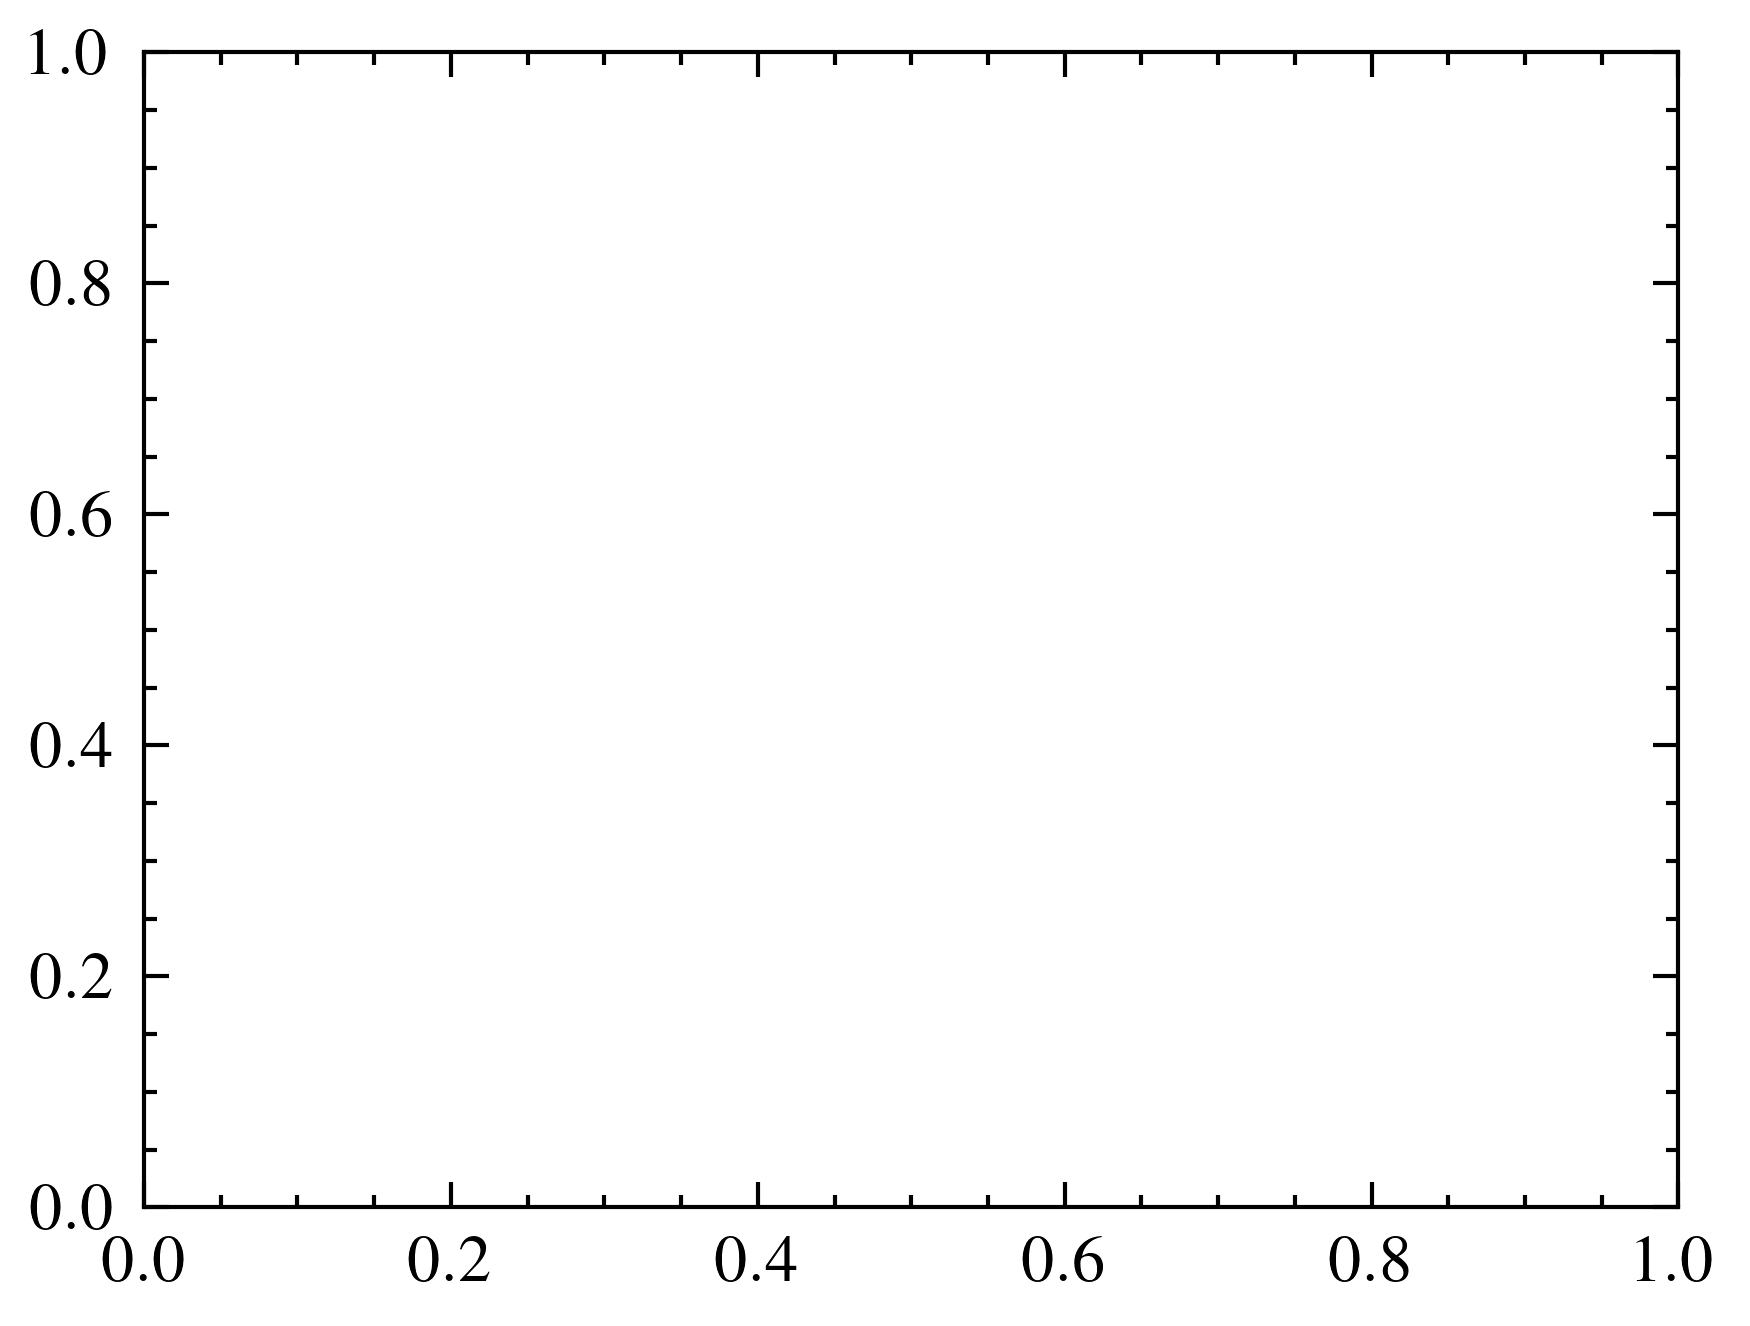

In [3]:
print(dW_refine[0].shape,dW_refine[1].shape,dW_refine[2].shape,dW_refine[3].shape,dW_refine[4].shape,dW_refine[5].shape,dW_refine[6].shape,dW_refine[7].shape,dW_refine[8].shape)

for i in range(0,8+1):
    time = jnp.linspace(0, tmax, 2**(i))
    plt.plot(time,W_refine[i][:,0,0],label=str(i))
plt.legend()

# import plotly.graph_objects as go
# fig = go.Figure()
# for i in range(0, 9):
#     time = jnp.linspace(0, tmax, nmax*2**(i))
#     fig.add_trace(go.Scatter(x=time, y=W_refine[i][:, 0, 0], mode='lines', name=f'Refinement {i}'))
# fig.update_layout(
#     title="Interactive Plot of W_refine",
#     xaxis_title="Time",
#     yaxis_title="W_refine Values",
#     legend_title="Refinement Levels",
# )
#fig.show()

Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [4]:
signal_params = ConfigDict(KDV_params_exact_traveling)
print(signal_params)

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: new_traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 1.0
nx: 64
tmax: 1.0
xmax: 3.141592653589793
xmin: -3.141592653589793



Next, we update the method to have 256 spatial resolution, as to mimimise spatial errors, we choose $dt = (10^{-5}) i$, for $i=1,...,1/16$. $T_{max} = 0.01$. 

In [5]:
signal_params.update(method='Dealiased_SETDRK4',dt=1e-5,tmax= 0.1,nx = 256,P=1,S=0,noise_magnitude=5,initial_condition='new_traveling_wave')

Now we continue to define a stochastic ensemble

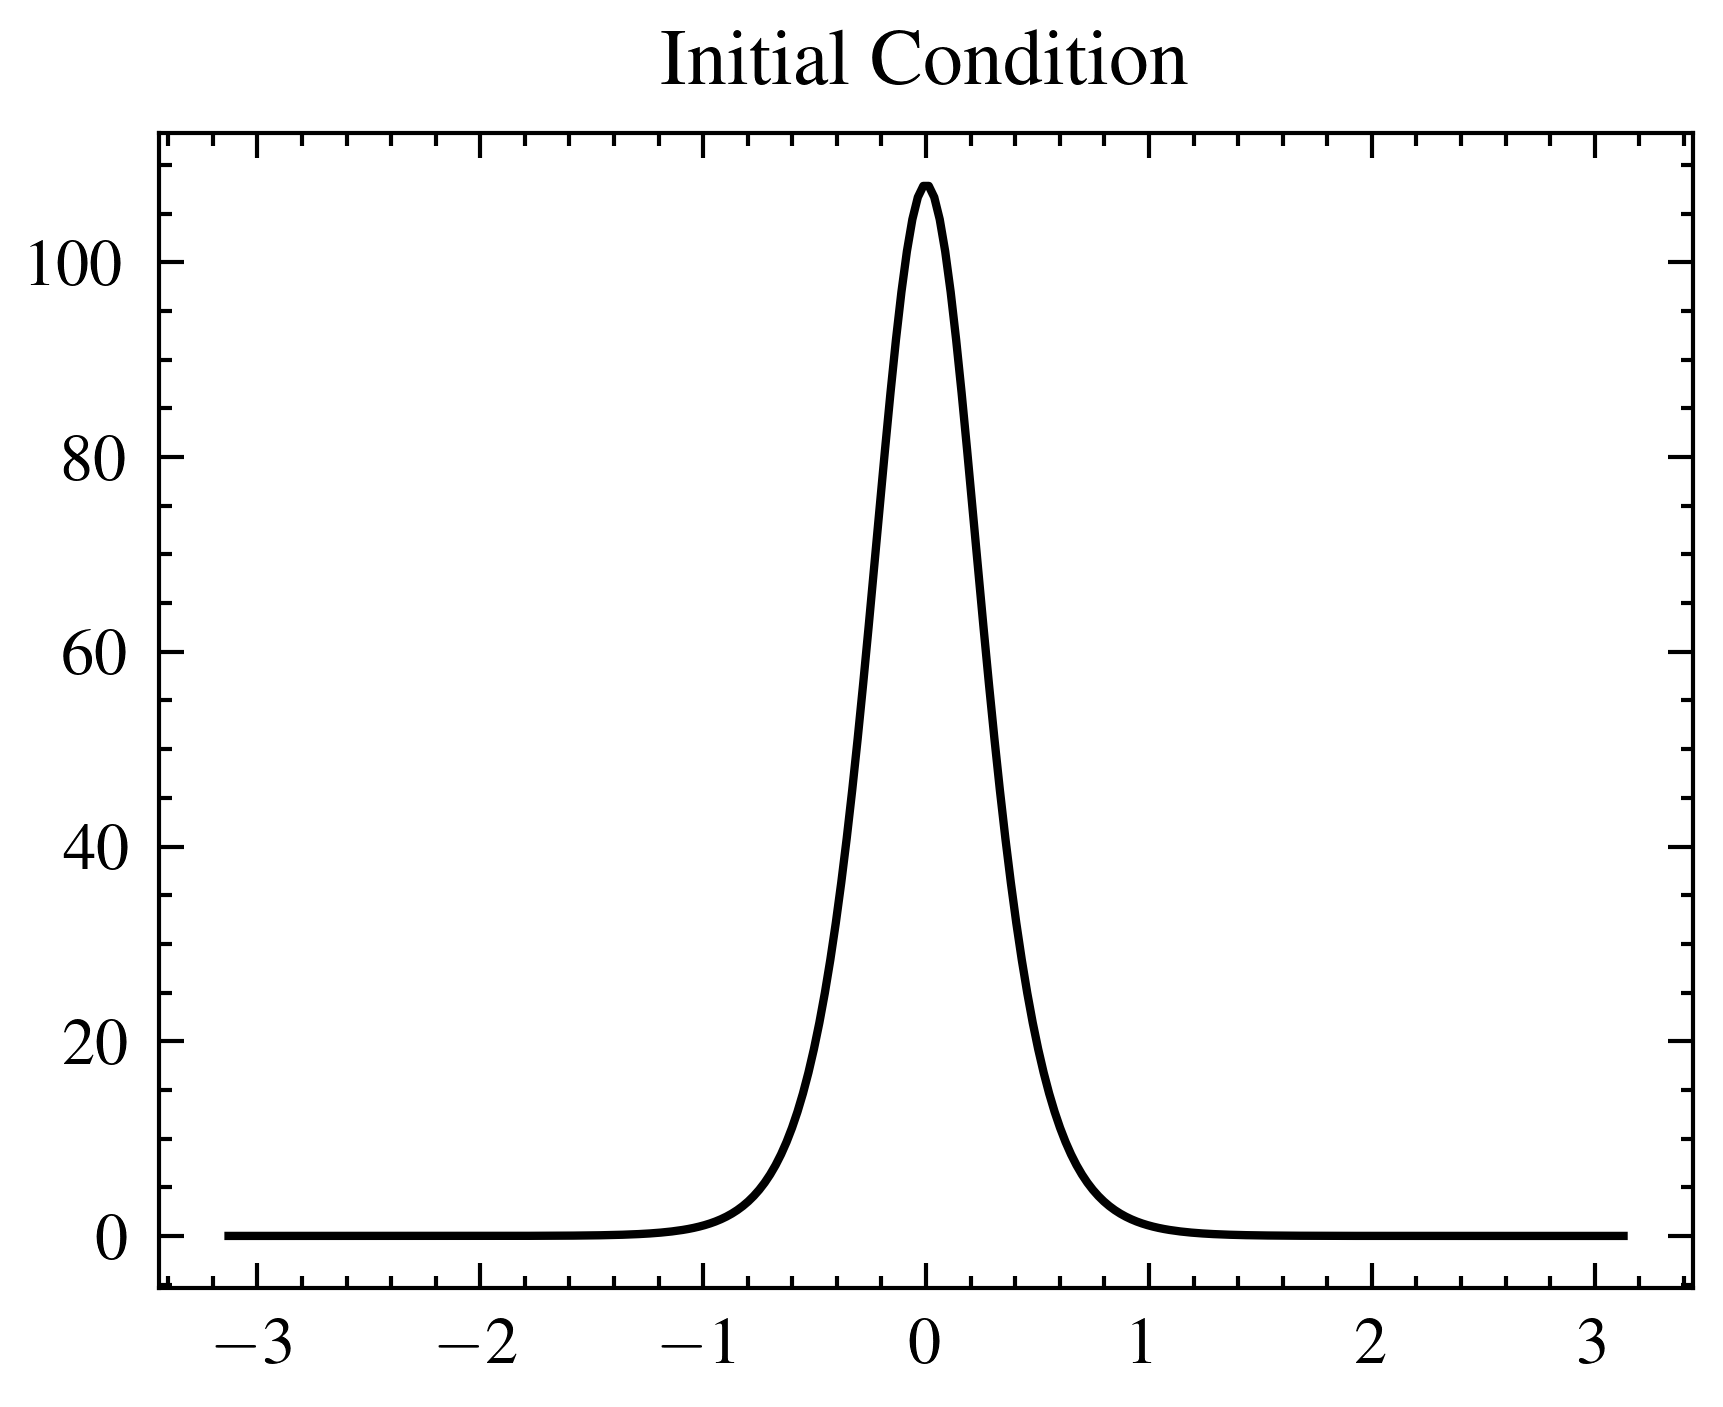

In [6]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
plt.title("Initial Condition")
plt.plot(signal_model.x, initial_signal[0,:])
plt.show()

It is important to note that the $\cosh^2(x)$ travelling wave assumes vanishing contribution at infinity $u=u_x=u_{xxx}=0$ for $x=\pm \infty$.
We are implementing this $\cosh^2(x)$ travelling wave solution with periodic boundary conditions on $x\in [-\pi,\pi]$.
This is technically incorrect, as the wave solution has finite values of $u,u_x,u_{xx}$, at $[-\pi,\pi]$. Resulting in a periodic discontinuity in the first derivative. 


In [7]:
key1 = jax.random.PRNGKey(0)
dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
dW = dW
final, all = signal_model.run(initial_signal, signal_model.nmax,dW) #the final input is scan length? 
print(final.shape,all.shape)
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)

(1, 256) (10000, 1, 256)
(1, 256)
(10000, 1, 256)
(10001, 1, 256)


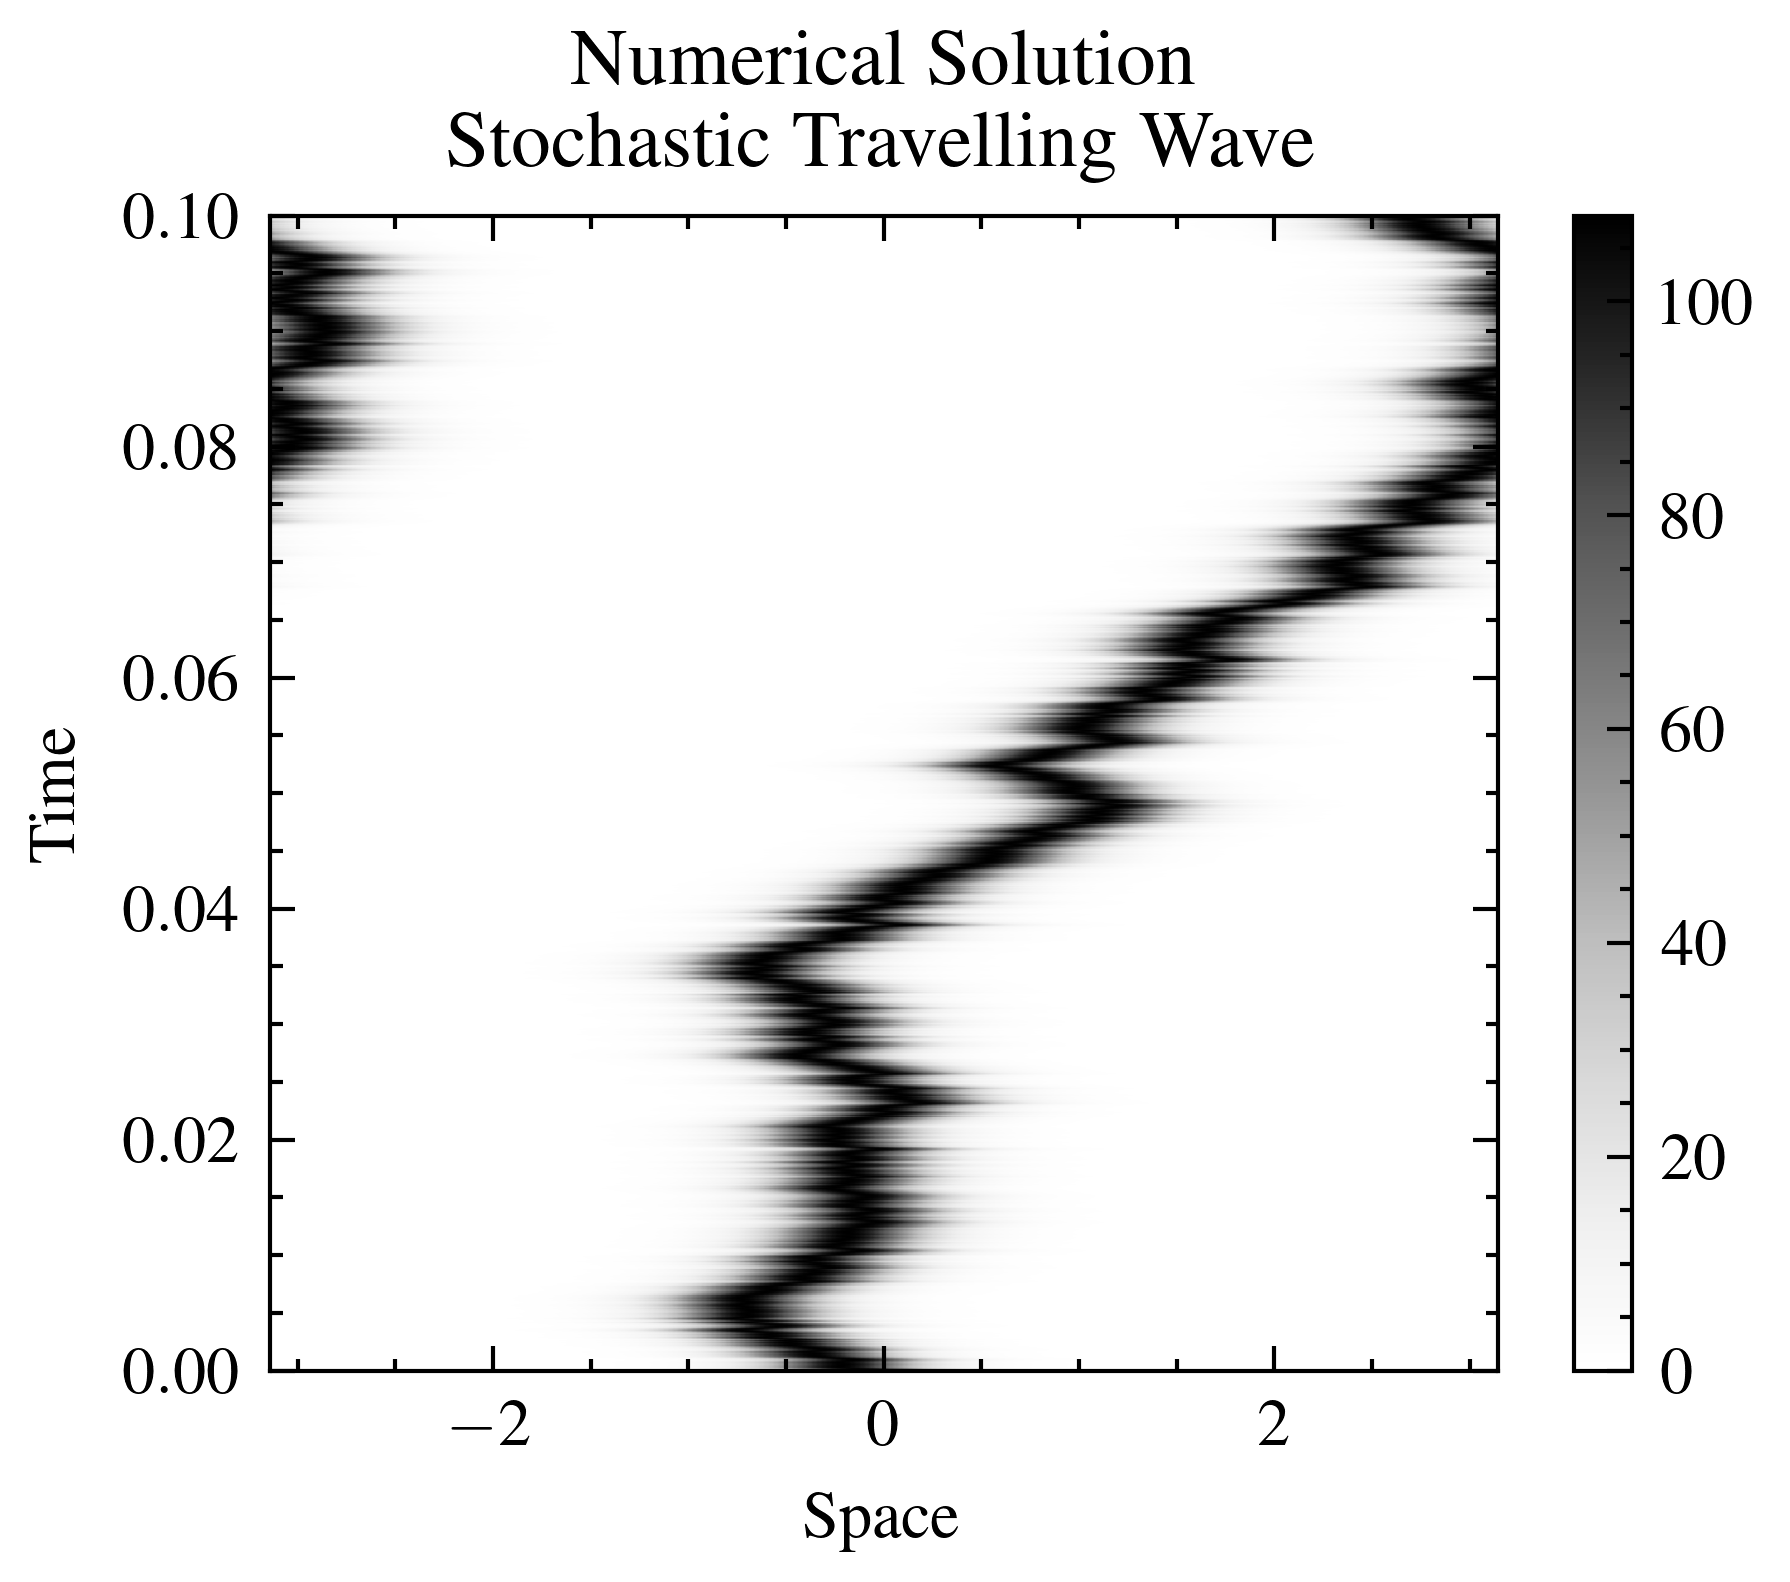

In [8]:
plt.title('Numerical Solution \n Stochastic Travelling Wave')
plt.imshow(signal[:,0,:],extent = [signal_model.params.xmin, signal_model.params.xmax,0,signal_model.params.tmax],aspect='auto',cmap='Grays',origin='lower')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time')
plt.show()

In [9]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal

<class 'jaxlib.xla_extension.ArrayImpl'>
10000
(1, 256)
(1, 256)


Consider the stochastic KdV equation 
\begin{align}
d u + uu_x + u_{xxx} + \xi u_x \circ dW = 0.
\end{align}
Define the stochastic moving frame $X(t,x) = x - \xi W(t)$, $dX = \xi dW$, it is a stochastic process.
Define a new function in the moving frame $v(t,X(t,x)) = u(t,x)$. Such that 
\begin{align}
du = dv(t,X(t,x)) = \partial_t v - \frac{\partial v}{\partial X} \xi dW  = \partial_t v - \frac{\partial u}{\partial x} \xi dW
\end{align}
Transforms the stochastic KdV equation, into a deterministic pde, such that one can derive 
$\cosh^2( (x - 4 \beta^2 t_n - \frac{1}{2} W(t_n)) $

In [10]:
from jax import vmap

W = jnp.cumsum(dW, axis=0)
W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
print(W.shape)
W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
W_new = W_new.at[1:,:,:].set(W)

E = signal_model.params.E
nmax = signal_model.nmax
nx = signal_model.params.nx
x = signal_model.x
xmax = signal_model.params.xmax
xmin = signal_model.params.xmin
dt = signal_model.params.dt

analytic = jnp.zeros([nmax+1, E, nx])

initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
    return initial_condition_jitted((x - 6 * 6 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)
compute_ans_vmap = vmap(compute_ans, in_axes=(0, None, None, None, None, None, None))
# Generate the range of n values
n_values = jnp.arange(signal_model.nmax + 1)
# Compute analytic using the vectorized function
analytic = compute_ans_vmap(n_values, x, dt, W_new, xmax, E, signal_params.initial_condition)
# evaluation takes a couple of mins at higher resolution. as compared with the numerical implementation, which is fast


(10000, 1, 1)


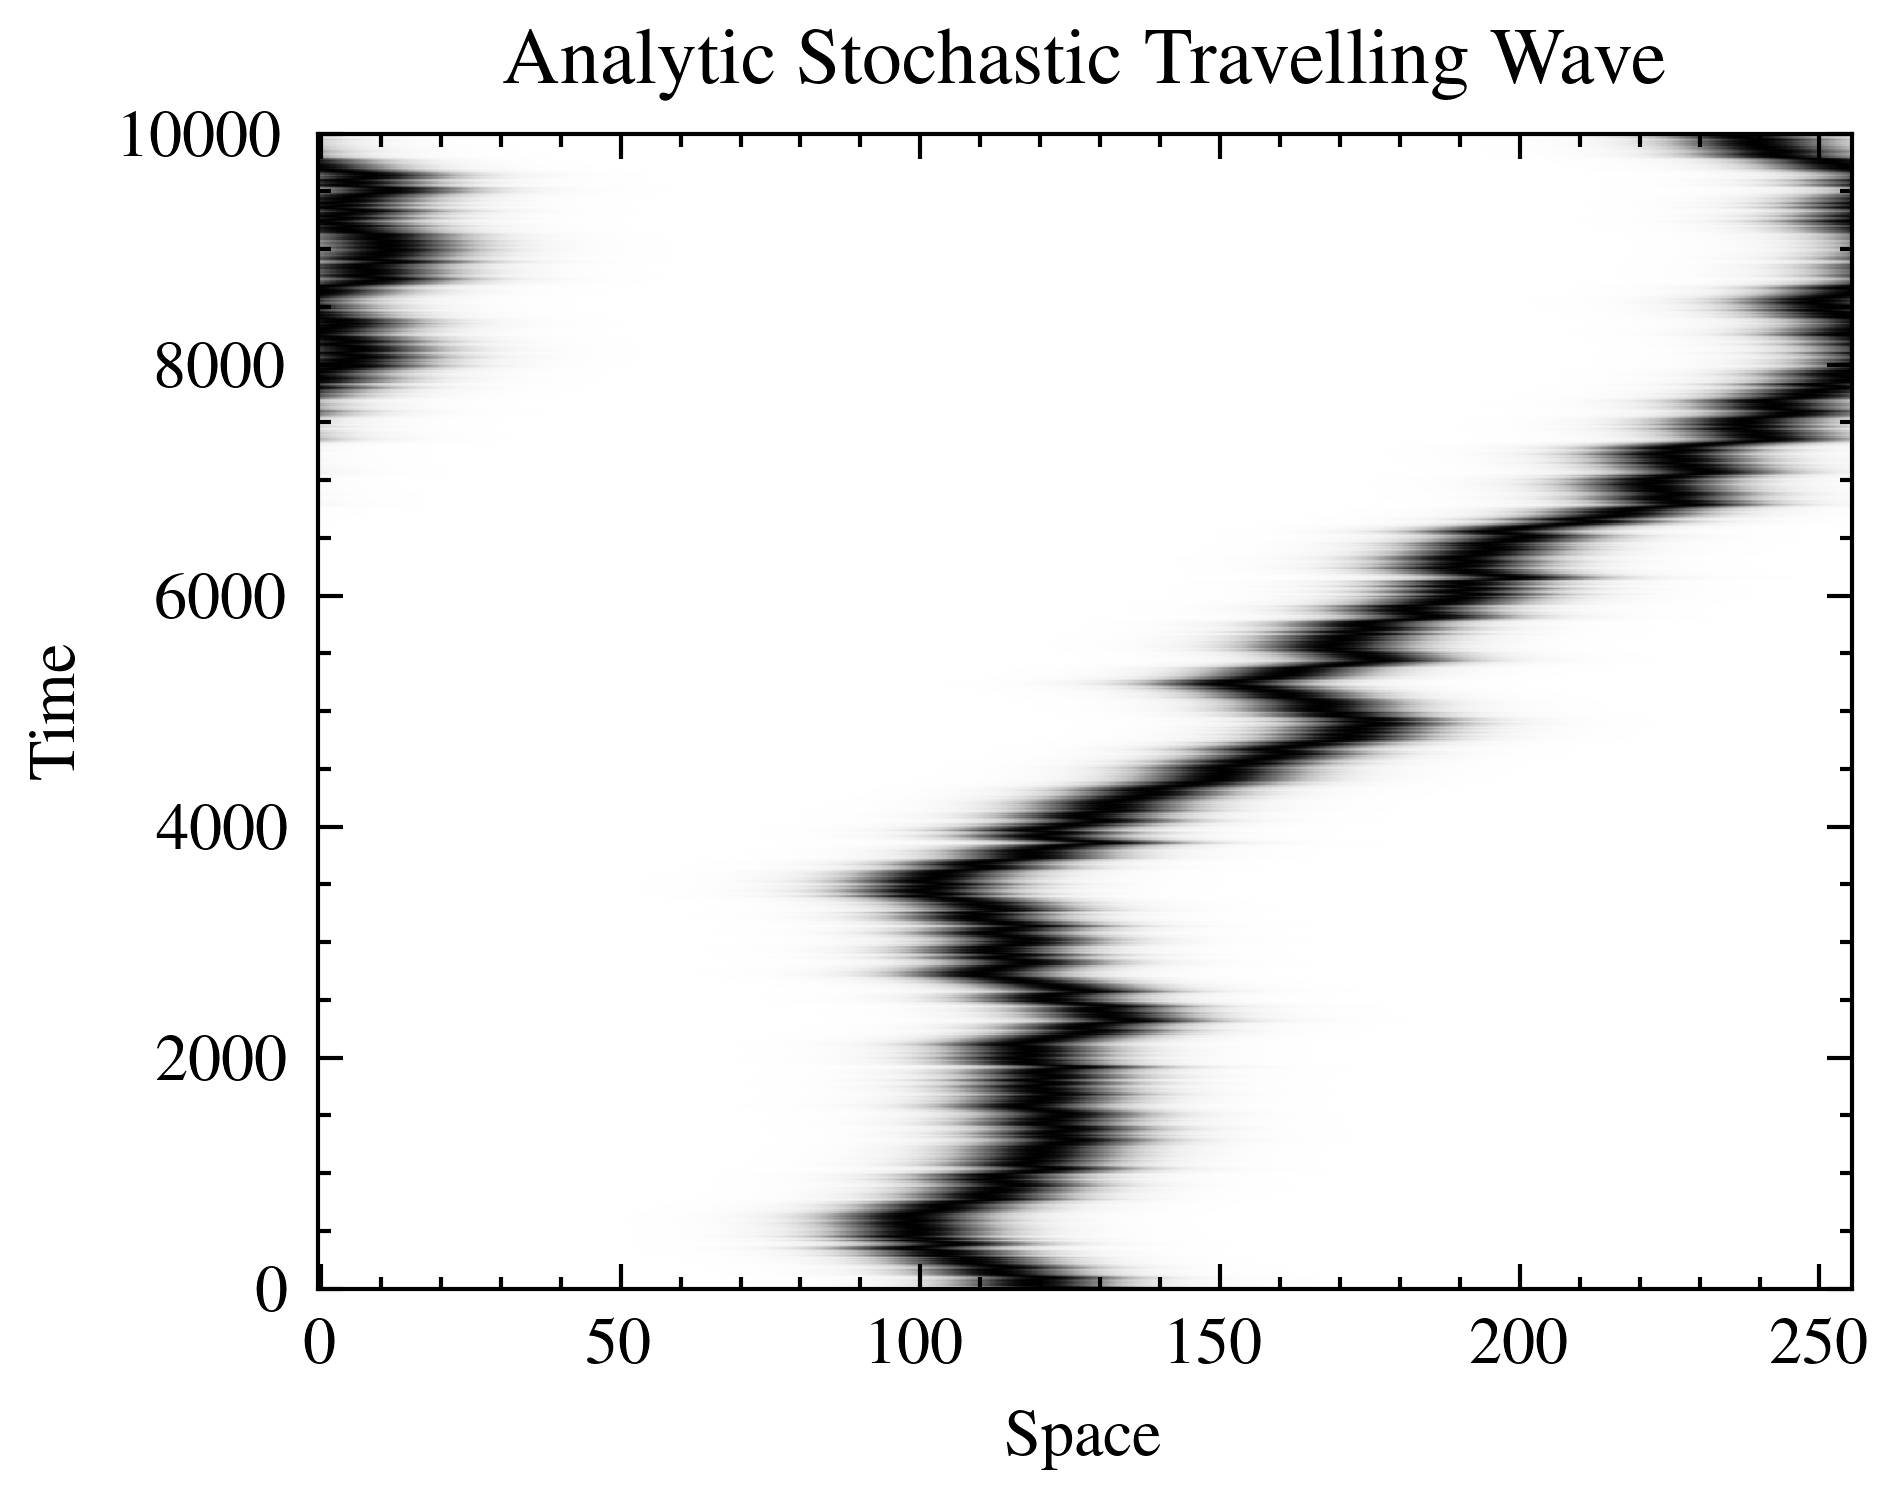

In [11]:
plt.title('Analytic Stochastic Travelling Wave')
plt.imshow(analytic[:,0,:],aspect='auto',cmap='Grays',origin='lower')
plt.xlabel('Space')
plt.ylabel('Time')
plt.show()

In [12]:
def plot(da_step):
    plt.title(f"da_step = {da_step}")
    plt.plot(signal_model.x, signal[da_step,:,:].T, color='k',linewidth=0.2,label='signal')
    plt.plot(signal_model.x, analytic[da_step,:,:].T, color='r',linewidth=0.2,label='analytic')
    plt.legend()
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))


(10001, 1, 256) (10001, 1, 256)


interactive(children=(IntSlider(value=5000, description='da_step', max=10000), Output()), _dom_classes=('widge…

<function __main__.plot(da_step)>

We plot the difference between numerical and analytic solutions

In [13]:
def plot(da_step):
    plt.title('Difference between numerical and analytic solutions')
    plt.plot(signal_model.x, signal[da_step,:,:].T-analytic[da_step,:,:].T, color='k',linewidth=2)
    plt.legend(['signal'])
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))

(10001, 1, 256) (10001, 1, 256)


interactive(children=(IntSlider(value=5000, description='da_step', max=10000), Output()), _dom_classes=('widge…

<function __main__.plot(da_step)>

In [14]:
def relative_error(signal, analytic):
    return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)

print( jnp.linalg.norm(signal[1,:,:]- analytic[1,:,:]))# this should be zero
print(relative_error(signal[:,:,:], analytic[:,:,:]))#space time relative error.

0.00010387560852503817
0.000443999008817696


Here we try and produce all the plots in one sweep, rather than rerunning seperately. 

0
1e-05
1
5e-06
2
2.5e-06
3
1.25e-06
4
6.25e-07
5
3.125e-07
6
1.5625e-07
7
7.8125e-08


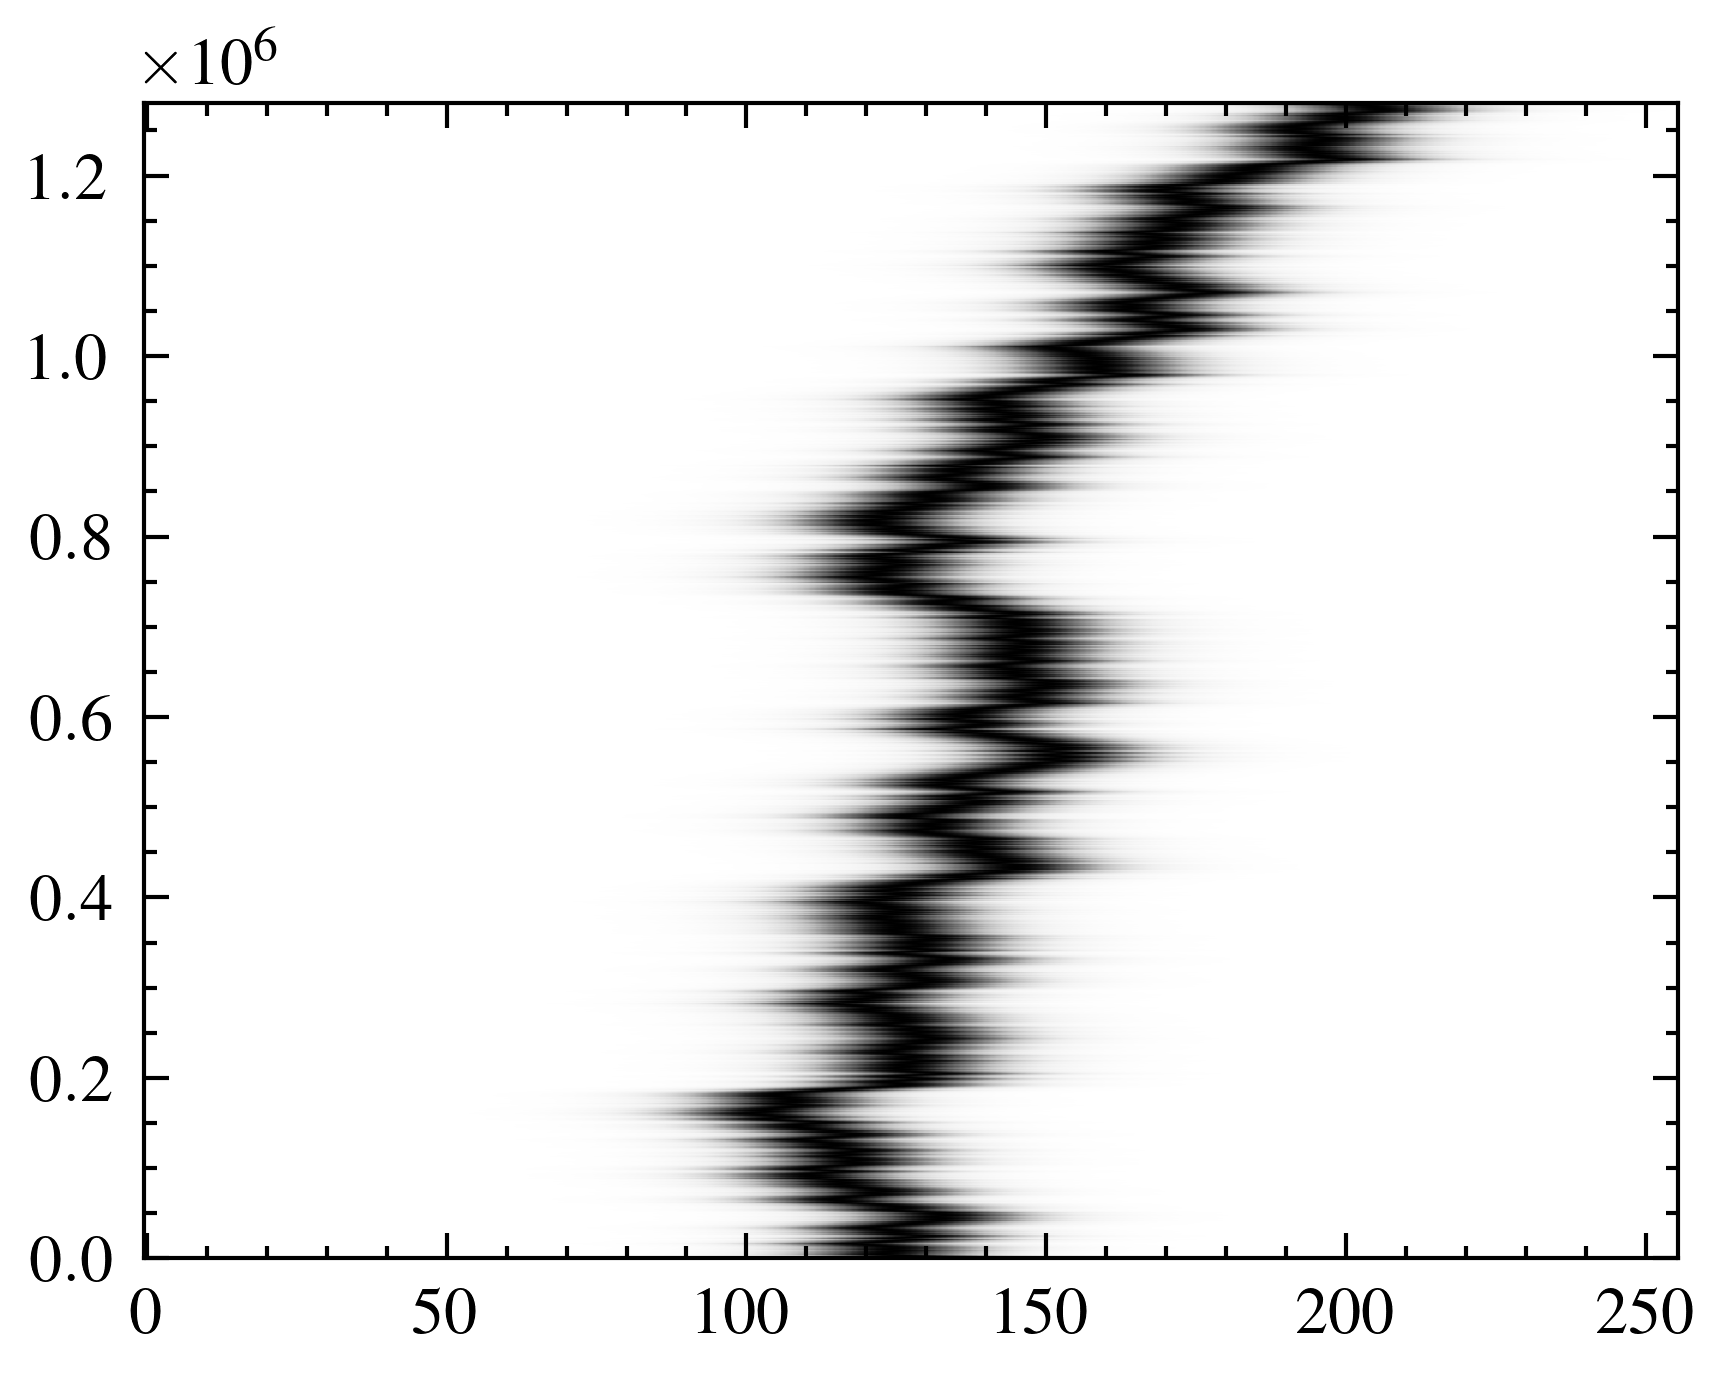

In [15]:
array = jnp.zeros(8)
for i in range(8):
    signal_params = ConfigDict(KDV_params_exact_traveling)
    signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 1e-5*1/2**i,tmax=0.1,nx=256,P=1,S=0,noise_magnitude=5)
    print(i)
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    key1 = jax.random.PRNGKey(0)
    dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
    dW = dW
    final, all = signal_model.run(initial_signal, signal_model.nmax, dW) #the final input is scan length? 
    plt.imshow(all[:,0,:],aspect='auto',cmap='Grays',origin='lower')
    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    W = jnp.cumsum(dW, axis=0)
    W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
    W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
    W_new = W_new.at[1:,:,:].set(W)

    E = signal_model.params.E
    nmax = signal_model.nmax
    nx = signal_model.params.nx
    x = signal_model.x
    xmax = signal_model.params.xmax
    xmin = signal_model.params.xmin
    dt = signal_model.params.dt
    print(dt)
    analytic = jnp.zeros([nmax+1, E, nx])
    
    initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
    def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
        return initial_condition_jitted((x - 6 * 6 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)
    compute_ans_vmap = vmap(compute_ans, in_axes=(0, None, None, None, None, None, None))
    # Generate the range of n values
    n_values = jnp.arange(signal_model.nmax + 1)
    # Compute analytic using the vectorized function
    analytic = compute_ans_vmap(n_values, x, dt, W_new, xmax, E, signal_params.initial_condition)


    def relative_error(signal, analytic):
        return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)
    
    array = array.at[i].set( relative_error(signal[:,:,:], analytic[:,:,:]) )
plt.show()

[4.43999009e-04 1.20161936e-04 3.06362906e-05 6.68483666e-06
 1.86257040e-06 4.69825604e-07 1.28985874e-07 4.27913925e-08] (8,)


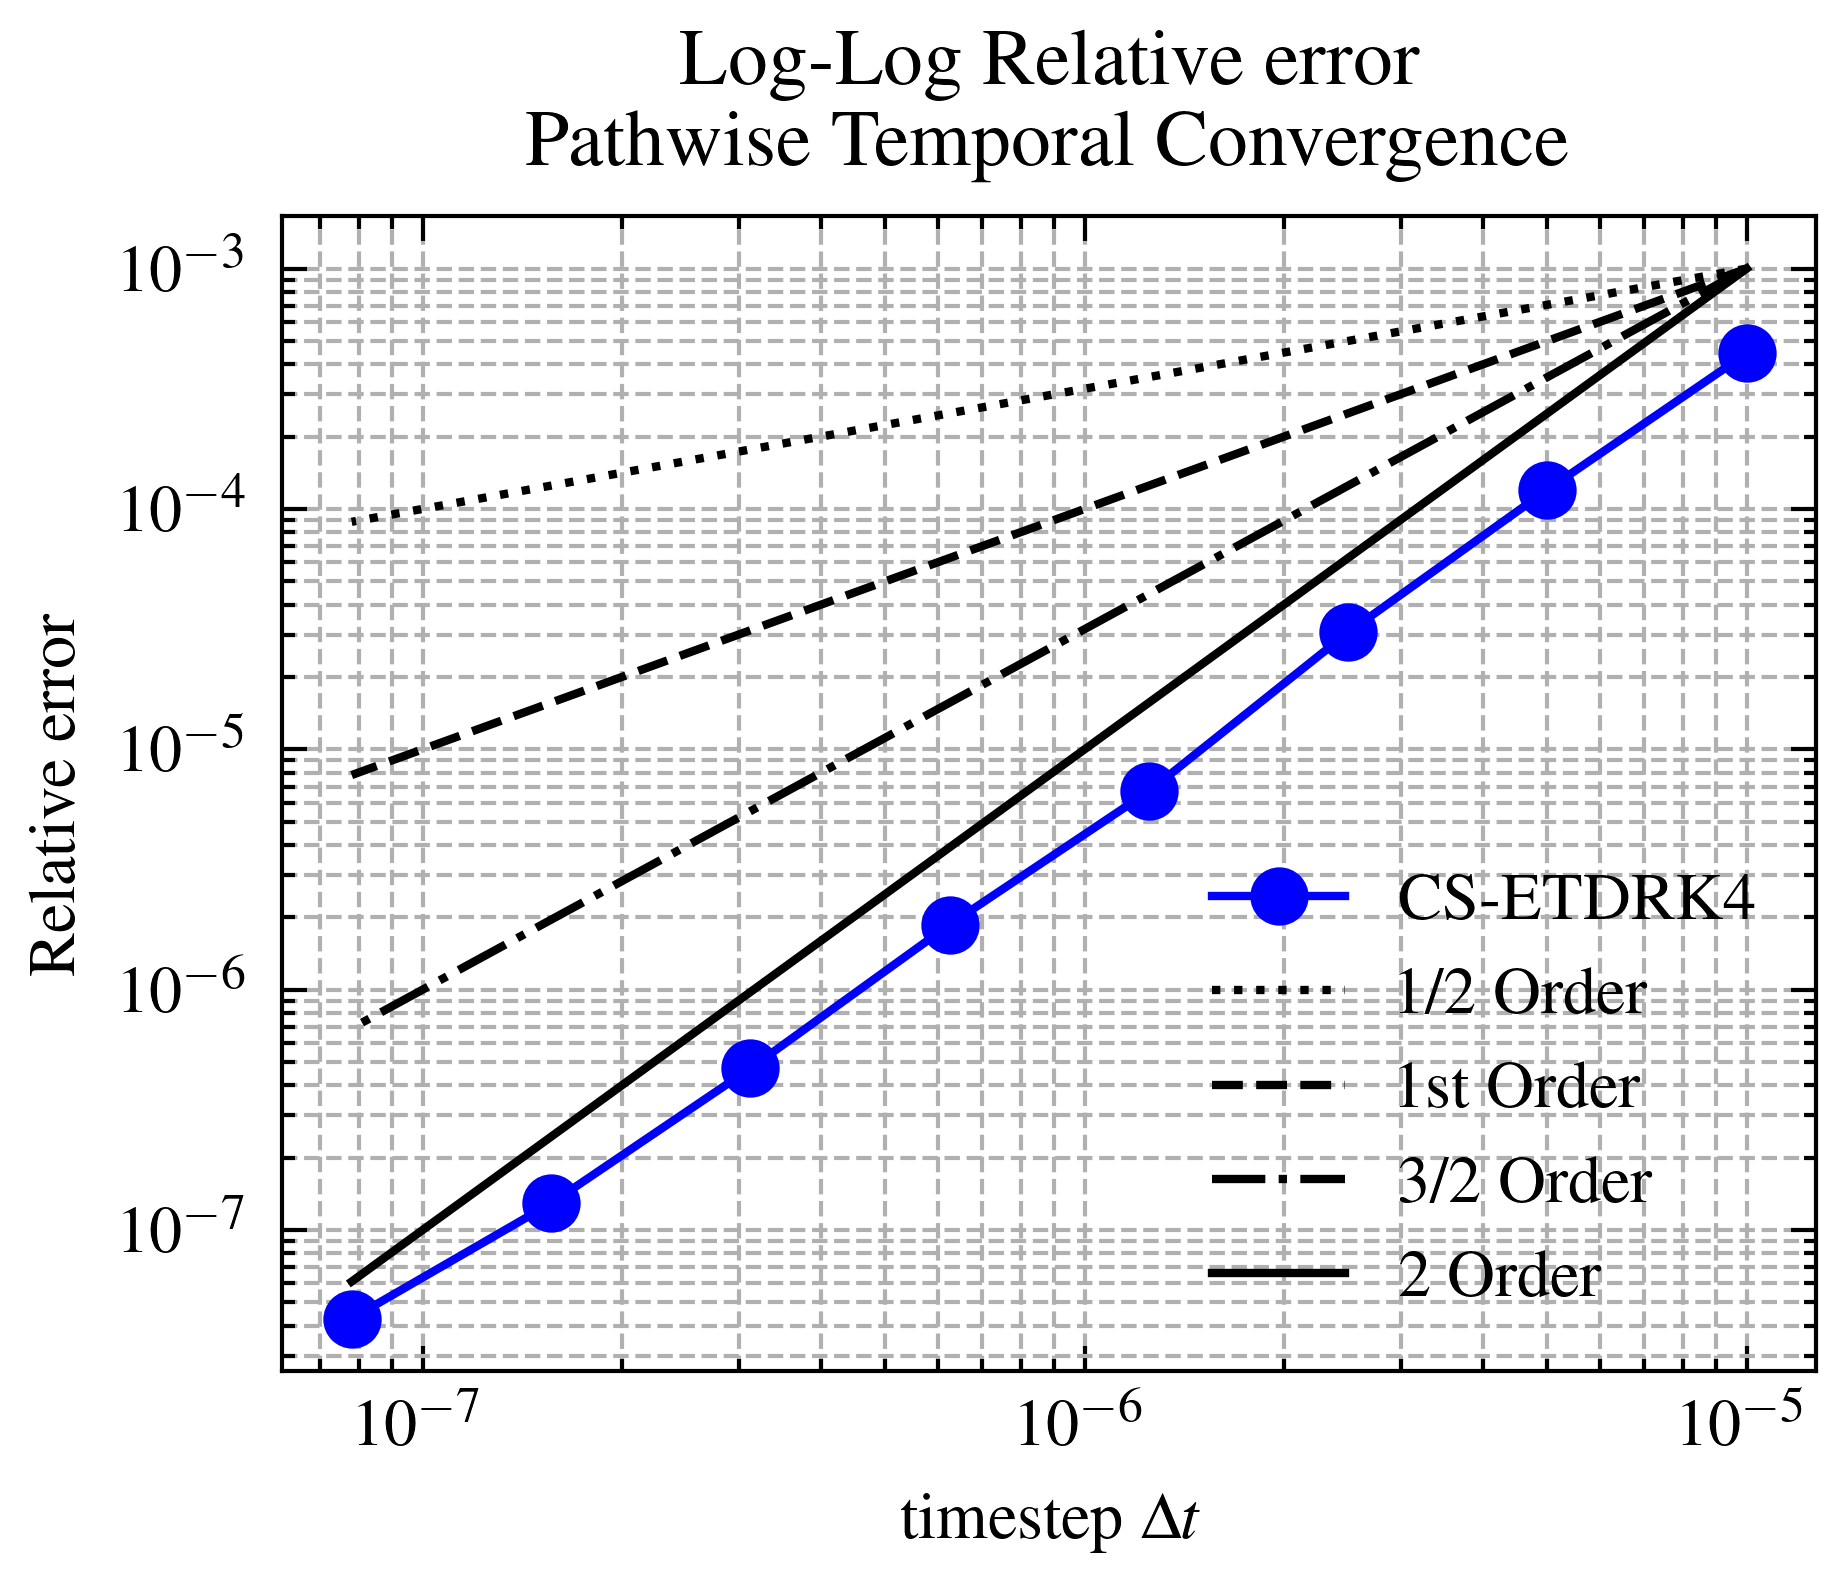

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-5*np.asarray([1.,1/2,1/4,1/8,1/16,1/32,1/64,1/128])
values = array
print(values,values.shape)
a = 1e-5
v=0.001
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
plt.loglog(dt,values, marker='o', linestyle='-', color='b',label='CS-ETDRK4')

plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_2.png',bbox_inches='tight',dpi=300)
plt.show()

In [1]:
max_number = 8
array = jnp.zeros(max_number)
array2 = jnp.zeros(max_number)
for i in range(max_number):
    signal_params = ConfigDict(KDV_params_exact_traveling)

    signal_params.update(E=1,method='Dealiased_IFSRK4',dt= 1e-5*1/2**i,tmax=0.01,nx=256,P=1,S=0,noise_magnitude=5,initial_condition='steep_traveling_wave')
    print(i)# somehow here the timestep needs to be reduced?
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    signal_params_2 = ConfigDict(KDV_params_exact_traveling)
    signal_params_2.update(E=1,method='Dealiased_SETDRK4',dt= 1e-5*1/2**i,tmax=0.01,nx=256,P=1,S=0,noise_magnitude=5,initial_condition='steep_traveling_wave')
    signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params_2)


    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    key1 = jax.random.PRNGKey(0)
    dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
    dW = dW
    final, all = signal_model.run(initial_signal, signal_model.nmax, dW) #the final input is scan length? 
    final2, all2 = signal_model_2.run(initial_signal, signal_model.nmax, dW)

    plt.imshow(all[:,0,:],aspect='auto',cmap='Grays',origin='lower')
    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    signal2 = jnp.concatenate([initial_signal[None,...], all2], axis=0)

    W = jnp.cumsum(dW, axis=0)
    W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
    W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
    W_new = W_new.at[1:,:,:].set(W)

    E = signal_model.params.E
    nmax = signal_model.nmax
    nx = signal_model.params.nx
    x = signal_model.x
    xmax = signal_model.params.xmax
    xmin = signal_model.params.xmin
    dt = signal_model.params.dt
    tmax = signal_model.params.tmax
    print('dt:',dt,'nt',nmax,'Tmax',tmax)
    analytic = jnp.zeros([nmax+1, E, nx])
    initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
    def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
        return initial_condition_jitted((x - 6 * 6 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)
    compute_ans_vmap = vmap(compute_ans, in_axes=(0, None, None, None, None, None, None))
    # Generate the range of n values
    n_values = jnp.arange(signal_model.nmax + 1)
    # Compute analytic using the vectorized function
    analytic = compute_ans_vmap(n_values, x, dt, W_new, xmax, E, signal_params.initial_condition)

    def relative_error(signal, analytic):
        return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)
    
    array = array.at[i].set( relative_error(signal[:,:,:], analytic[:,:,:]) )
    array2 = array2.at[i].set( relative_error(signal2[:,:,:], analytic[:,:,:]) )

    plt.show()

NameError: name 'jnp' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-3*np.asarray([2**-i for i in range(0,max_number)])
#dt = 1e-5*np.asarray([1.,1/2,1/4,1/8,1/16,1/32,1/64,1/128])
values = array
print(values)
print(array2)
print(values.shape)
a = 1e-5
v=0.000001
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
plt.loglog(dt,values, marker='o', linestyle='-', color='r',label='IFSRK4')
plt.loglog(dt,array2, marker='o', linestyle='-', color='b',label='CS-ETDRK4')

plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_2.png',bbox_inches='tight',dpi=300)
plt.show()